In [1]:
import csv
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import os.path
from scipy.stats import multivariate_normal


In [2]:
def load_data(filename):
    """Load data from the csv log

    Parameters:
    filename (str)  -- the name of the csv log

    Returns:
    data (dict)     -- the logged data with data categories as keys
                       and values list of floats
    """
    is_filtered = False
    if os.path.isfile(filename + "_filtered.csv"):
        f = open(filename + "_filtered.csv")
        is_filtered = True
    else:
        f = open(filename + ".csv")

    file_reader = csv.reader(f, delimiter=',')

    # Load data into dictionary with headers as keys
    data = {}
    header = ["X", "Y", "Z", "Time Stamp", "Latitude", "Longitude",
              "Yaw", "Pitch", "Roll", "AccelX", "AccelY", "AccelZ"]
    for h in header:
        data[h] = []

    row_num = 0
    f_log = open("bad_data_log.txt", "w")
    for row in file_reader:
        for h, element in zip(header, row):
            # If got a bad value just use the previous value
            try:
                data[h].append(float(element))
            except ValueError:
                data[h].append(data[h][-1])
                f_log.write(str(row_num) + "\n")

        row_num += 1
    f.close()
    f_log.close()

    return data, is_filtered

In [3]:
def wrap_to_pi(angle):
    """Wrap angle data in radians to [-pi, pi]

    Parameters:
    angle (float)   -- unwrapped angle

    Returns:
    angle (float)   -- wrapped angle
    """
    while angle >= math.pi:
        angle -= 2*math.pi

    while angle <= -math.pi:
        angle += 2*math.pi
    return angle


In [4]:
def convert_gps_to_xy(lat_gps, lon_gps, lat_origin, lon_origin):
    """Convert gps coordinates to cartesian with equirectangular projection

    Parameters:
    lat_gps     (float)    -- latitude coordinate
    lon_gps     (float)    -- longitude coordinate
    lat_origin  (float)    -- latitude coordinate of your chosen origin
    lon_origin  (float)    -- longitude coordinate of your chosen origin

    Returns:
    x_gps (float)          -- the converted x coordinate
    y_gps (float)          -- the converted y coordinate
    """
    x_gps = EARTH_RADIUS*(math.pi/180.)*(lon_gps - lon_origin)*math.cos((math.pi/180.)*lat_origin)
    y_gps = EARTH_RADIUS*(math.pi/180.)*(lat_gps - lat_origin)

    return x_gps, y_gps


In [5]:
data17, _ = load_data("2020_2_26__17_21_59_filtered")

In [64]:
#accleration covariance calculations
#assuming uncorrelated Accelx, accelY
var_accX = np.var(data17["AccelX"][669:])
var_accY = np.var(data17["AccelY"][669:])
covar_u_t = np.array([[var_accX, 0],
                      [0, var_accY]])
print(var_accX, var_accY)

0.2597510387811634 0.14175408587257618


In [65]:
HEIGHT_THRESHOLD = 0.0  # meters
GROUND_HEIGHT_THRESHOLD = -.4  # meters
DT = 0.1
X_LANDMARK = 5.  # meters
Y_LANDMARK = -5.  # meters
EARTH_RADIUS = 6.3781E6  # meters

In [66]:
yaw_corrected = np.zeros(len(data17["Yaw"][669:]))
yaw_data = data17["Yaw"][669:]

for i in range(len(data17["Yaw"][669:])):
    
    yaw_corrected[i] = wrap_to_pi(yaw_data[i]*(np.pi/180))

yaw_corrected

array([ 0.01090831,  0.        ,  0.00109083, -0.00436332,  0.        ,
       -0.00109083,  0.00872665,  0.00436332,  0.00654498,  0.00545415,
        0.00654498,  0.00654498,  0.00763582,  0.00654498,  0.00654498,
        0.00654498,  0.00654498,  0.00545415,  0.00545415,  0.00545415,
        0.00545415,  0.00545415,  0.00654498,  0.00654498,  0.00654498,
        0.00654498,  0.00763582,  0.00763582,  0.00763582,  0.00763582,
        0.00763582,  0.00763582,  0.00763582,  0.00763582,  0.00763582,
        0.00763582,  0.00763582,  0.00763582])

In [67]:
#calculating sensor covariance matrix. We assume that all measurements are independent, and that the covariance is equal
#to the stationary variance
#recall: measurement vector is Zx, Zy, yaw
var_Zx = np.var(data17["X"][669:])
var_Zy = np.var(data17["Y"][669:])
var_yaw = np.var(yaw_corrected)
covar_z = np.array([[var_Zx, 0, 0],
                    [ 0, var_Zy, 0],
                    [0, 0, var_yaw]])
print(var_Zx, var_Zy, var_yaw)

0.0001698159186405823 0.0004478908815990326 8.613675903064495e-06


In [68]:
def propogate_state(x_t_prev, u_t):
    """Propogate/predict the state based on chosen motion model

    Parameters:
    x_t_prev (np.array)  -- the previous state estimate
    u_t (np.array)       -- the current control input

    Returns:
    x_bar_t (np.array)   -- the predicted state
    """
    """STUDENT CODE START"""
    #Xt = [xg, yg, yaw, yaw_t-1, Vx, Vy, omega]'
    angle_correction = x_t_prev[2]
    #angle_correction = wrap_to_pi(x_t_prev[2])

    A_matrix = np.array([[1, 0, 0, 0, DT, 0, 0],
                         [0, 1, 0, 0, 0, DT, 0],
                         [0, 0, 1, 0, 0, 0, DT],
                         [0, 0, 1, 0, 0, 0, 0 ],
                         [0, 0, 0, 0, 1, 0, 0 ],
                         [0, 0, 0, 0, 0, 1, 0 ],
                         [0, 0, 1/DT, -1/DT, 0, 0, 0]])
    
    #angle_correction = wrap_to_pi(2*np.pi - x_t_prev[2])
    
    
    #angle_correction = wrap_to_pi(-x_t_prev[2])


    B_matrix = np.array([[1/2*np.square(DT)*np.cos(angle_correction), 0],
                     [-1/2*np.square(DT)*np.sin(angle_correction), 0],
                     [0, 0],
                     [0, 0],
                     [DT*np.cos(angle_correction), 0], 
                     [-DT*np.sin(angle_correction), 0],
                     [0, 0]])

    x_bar_t = A_matrix@x_t_prev + B_matrix@u_t
    x_bar_t[2] = wrap_to_pi((A_matrix@x_t_prev)[2] + (B_matrix@u_t)[2])
    x_bar_t[3] = wrap_to_pi((A_matrix@x_t_prev)[3] + (B_matrix@u_t)[3])
    
    
    x_bar_t[6] = wrap_to_pi(x_t_prev[2] - x_t_prev[3]) / DT
    #x_bar_t[6] = (wrap_to_pi(x_t_prev[2]) - wrap_to_pi(x_t_prev[3])) / DT
    #x_bar_t[2] = wrap_to_pi(x_bar_t[2])

    """STUDENT CODE END"""

    return x_bar_t

In [109]:
def propogate_state_2(x_t_prev, u_t):
    """
    propogate the state using random forward motion
    
    Assumes no slide slipping
    """
    
#     #based on time to travel on side in experiment. assuming constant velocity, m/s
    mean_speed = 0.5*DT*u_t[0]
    stdev_speed = np.abs(mean_speed/2) #arbitrary, picked to ensure 0 m/s possible

    random_velocity = np.random.normal(loc = mean_speed, scale = stdev_speed)


    
    
    mean_yaw = 0
    stdev_yaw = 2.5*np.pi/180
    
    random_delta_yaw = np.random.normal(loc = mean_yaw, scale = stdev_yaw)
    
    curr_yaw = wrap_to_pi(x_t_prev[2] + random_delta_yaw)
    
    rot = np.array([[np.cos(curr_yaw), np.sin(curr_yaw)],
                    [-np.sin(curr_yaw), np.cos(curr_yaw)]])
    
    global_velocities = rot @ np.array([random_velocity, 0])
    
    x_t = np.zeros((3,1))
    x_t[0] = x_t_prev[0] + DT*global_velocities[0]
    x_t[1] = x_t_prev[1] + DT*global_velocities[1]
    x_t[2] = curr_yaw
    
    x_t = x_t.flatten()
    
    return x_t    

## State Representation

### At each time step, the ith row of the particle matrix has the states corresponding to the ith particle 

In [110]:
def getWeight(x_t, z_t, covar_z_t):
    
    estimated = x_t[0:3]
    
    #print(estimated)
    
    weight = multivariate_normal.pdf(z_t, mean=estimated, cov=covar_z_t)
    
#     if weight == 0:
#         print("getWeight")
#         print('x_t')
#         print(x_t)
#         print('estimated')
#         print(estimated)
#         print('z_t')
#         print(z_t)
#         print('weight')
#         print(weight)
#         print("wtf")
    
    return weight
    

In [111]:
def prediction_step(x_t_prev, u_t, covar_u_t, z_t, covar_z_t):
    '''
    z_t is the bot's position in the global frame
    
    '''
    
    x_t_bar = np.zeros(x_t_prev.shape)
    weights = np.zeros(len(x_t_prev))
    
    for i in range(len(x_t_prev)):
        perturbed_u_t = np.zeros(2)
        
        # Get previous state
        prev_state = x_t_prev[i]
        
        # Perturb control input
        perturbed_u_t[0] = u_t[0] + np.random.normal(loc = 0, scale = np.sqrt(covar_u_t[0][0]))
        perturbed_u_t[1] = u_t[1] + np.random.normal(loc = 0, scale = np.sqrt(covar_u_t[1][1]))
        
        # Get new state using perturbed control input
        new_state = propogate_state_2(prev_state, perturbed_u_t)
        new_weight = getWeight(new_state, z_t, covar_z_t)

        
        # Store
        x_t_bar[i] = new_state
        weights[i] = new_weight
        
#     if np.isnan(np.sum(weights)):
#         print("hello")
#         print(x_t_prev)
#         print(z_t)
#         print(weights)
#         print('hiiii')
    
    weights_sum = weights/np.sum(weights)
    
#     if np.isnan(np.sum(weights_sum)):
#         print(x_t_prev)
#         print(z_t)
#         print(weights)
#         print(np.sum(weights))
    #print(np.sum(weights))
    
    
#     for i in range(len(x_t_prev)):
        
#         print("Particle # is: ", i)
#         print("Prev state is: ", x_t_prev[i])
#         print("propogated State is: ", x_t_bar[i])
#         print("Weight is: ", weights_sum[i])
#         print("current Max is: ", np.max(weights_sum[0:i+1]))
#         print()
        
    return x_t_bar, weights_sum
        
    

In [112]:
def correction_step(x_bar_t, weights):
    
    x_t = np.zeros(x_bar_t.shape)
    #weights = np.zeros(len(x_bar_t))
        
    x_ind = np.arange(len(x_bar_t))
    
    for i in range(len(x_bar_t)):
        
        #print(x_ind.shape)
        #print(weights.shape)
        #print("correction")
        #print(np.sum(weights))
        
#         if np.isnan(np.sum(weights)):
#             print(weights)
        x_t_index = np.random.choice(a = x_ind, p = weights)
        
        x_t[i] = x_bar_t[x_t_index]
        #weights[i] = weights[x_t_index]
        
        print("resampled particle: ", x_t_index)
        
    return x_t
        

In [113]:
def initializeParticles(numParticles, numStates):
    
    states = np.zeros([numParticles, numStates])
    
    x_col = np.random.normal(loc = 0, scale = 0.1, size = numParticles)
    y_col = np.random.normal(loc = 0, scale = 0.1, size = numParticles)
    
    yaw_col = np.random.normal(loc = 0, scale = 0.01, size = numParticles)
    #yaw_col = np.where(yaw_col < 0, yaw_col + np.pi*2, yaw_col)
    
    states[:, 0] = x_col
    states[:, 1] = y_col
    states[:, 2] = yaw_col
    states[:, 3] = yaw_col
        
    return states
    
    

In [114]:
def initializeParticles2(numParticles, numStates):
    
    """
    initialize for only x, y, and theta
    """
    
    states = np.zeros([numParticles, numStates])
    
    x_col = np.random.normal(loc = 0, scale = 0.1, size = numParticles)
    y_col = np.random.normal(loc = 0, scale = 0.1, size = numParticles)
    
    yaw_col = np.random.normal(loc = 0, scale = 0.01, size = numParticles)
    #yaw_col = np.where(yaw_col < 0, yaw_col + np.pi*2, yaw_col)
    
    states[:, 0] = x_col
    states[:, 1] = y_col
    states[:, 2] = yaw_col
    
    return states

In [115]:
def main():
    
    filename = '2020_2_26__17_21_59_filtered'
    data, is_filtered = load_data(filename)
    
    # Load data into variables
    x_lidar = data["X"]
    y_lidar = data["Y"]
    z_lidar = data["Z"]
    time_stamps = data["Time Stamp"]
    lat_gps = data["Latitude"]
    lon_gps = data["Longitude"]
    yaw_lidar = data["Yaw"]
    pitch_lidar = data["Pitch"]
    roll_lidar = data["Roll"]
    x_ddot = data["AccelX"]
    y_ddot = data["AccelY"]
    
    lat_origin = lat_gps[0]
    lon_origin = lon_gps[0]
    
    # Initialize filter
    numParticles = 1000
    numStates = 3 #7
    #x_t_prev = initializeParticles(numParticles, numStates) #7 element state
    x_t_prev = initializeParticles2(numParticles, numStates) #3 element state
    
    # Store particles and gps
    particles = np.empty((numParticles, numStates, len(time_stamps)))
    vis_particles = np.empty((len(time_stamps), 2, numParticles))
    gps_estimates = np.empty((2, len(time_stamps)))
    
    index = 0
    
    for t, _ in enumerate(time_stamps):
        #print('Index')
        #print(index)
        index = index + 1
        
        u_t = np.array([x_ddot[t], y_ddot[t]])
        
        converted_yaw = wrap_to_pi(yaw_lidar[t] * np.pi / 180)
        
        z_t = np.array([5 - (x_lidar[t]*(-np.sin(converted_yaw)) + y_lidar[t]*(np.cos(converted_yaw))),
                        -5 - (x_lidar[t]*(-np.cos(converted_yaw)) - y_lidar[t]*(np.sin(converted_yaw))),
                        converted_yaw])
        
        # Prediction Step
        x_bar_t, weights = prediction_step(x_t_prev, u_t, covar_u_t, z_t, covar_z)
        #print(np.sum(weights))
        
        # Correction Step
        x_t = correction_step(x_bar_t, weights)
        
        
        # Explicitly set x_prev_t to x_t
        x_prev_t = x_t
        
        # Store shit
        particles[:, :, t] = x_t
        
        vis_particles[t,0] = particles[:, 0, t].flatten()
        vis_particles[t,1] = particles[:, 1, t].flatten()

        x_gps, y_gps = convert_gps_to_xy(lat_gps=lat_gps[t],
                                         lon_gps=lon_gps[t],
                                         lat_origin=lat_origin,
                                         lon_origin=lon_origin)
        gps_estimates[:, t] = np.array([x_gps, y_gps])
        
        
        if (t==30):
            return particles, vis_particles, gps_estimates
        
        
    return particles, vis_particles, gps_estimates
    

In [116]:
P_t, particles, gps_estimates = main()

resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  761
resampled particle:  932
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  761
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  644
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  761


resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  644
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  761
resampled particle:  932
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  932
resampled particle:  761
resampled particle:  932
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  761
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  761
resampled particle:  932
resampled particle:  761


resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644


resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  810
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  402
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644


resampled particle:  387
resampled particle:  73
resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  73
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  907
resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  387
resampled particle:  73
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  387
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  387
resampled particle:  387
resampled particle:  387
resampled particle:  387
res

resampled particle:  387
resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  387
resampled particle:  387
resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  73
resampled particle:  387
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  387
resampled particle:  387
resampled particle:  387
resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  387
resampled particle:  387
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  587
r

resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  587
resampled particle:  387
resampled particle:  387
resampled particle:  587
resampled particle:  387
resampled particle:  587
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  305
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932


resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  305
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932


resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  761
resampled particle:  603
resampled particle:  761
resampled particle:  387
resampled particle:  603
resampled particle:  603
resampled particle:  696
resampled particle:  603
resampled particle:  603
resampled particle:  387
resampled particle:  603
resampled particle:  696
resampled particle:  603
resampled particle:  603
resampled particle:  761
resampled particle:  603
resampled particle:  603
resampled particle:  696
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  387
resampled particle:  761
resampled particle:  387
resampled particle:  603
resampled particle:  761
resampled particle:  603
resampled particle:  603
resampled particle:  696
resampled particle:  603
resampled particle:  603
resampled particle:  696
resampled particle:  761
resampled particle:  696
resampled particle:  761
resampled particle:  603


resampled particle:  603
resampled particle:  603
resampled particle:  696
resampled particle:  603
resampled particle:  603
resampled particle:  696
resampled particle:  696
resampled particle:  603
resampled particle:  761
resampled particle:  387
resampled particle:  387
resampled particle:  696
resampled particle:  696
resampled particle:  761
resampled particle:  696
resampled particle:  761
resampled particle:  761
resampled particle:  603
resampled particle:  603
resampled particle:  761
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  387
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  387
resampled particle:  696
resampled particle:  696
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  696
resampled particle:  603
resampled particle:  603
resampled particle:  952
resampled particle:  603
resampled particle:  603
resampled particle:  761


resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644


resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644


resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  862
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  862
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644


resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  862
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603


resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603


resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  644
resampled particle:  644
resampled particle:  603
resampled particle:  603
resampled particle:  644
resampled particle:  603
resampled particle:  644
resampled particle:  603


resampled particle:  892
resampled particle:  761
resampled particle:  94
resampled particle:  94
resampled particle:  761
resampled particle:  761
resampled particle:  94
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  94
resampled particle:  892
resampled particle:  892
resampled particle:  94
resampled particle:  94
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  761
resampled particle:  94
resampled particle:  94
resampled particle:  761
resampled particle:  94
resampled particle:  892
resampled particle:  94
resampled particle:  892
resampled particle:  94
resampled particle:  94
resampled particle:  892
resampled particle:  761
resampled particle:  94
resampled particle:  761
resampled particle:  892
resampled particle:  761
resampled particle:  892
resampled particle:  761
resampled particle:  761
resampled particle:  892
resampled particle:  761
resampled par

resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  94
resampled particle:  892
resampled particle:  892
resampled particle:  94
resampled particle:  761
resampled particle:  892
resampled particle:  761
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  94
resampled particle:  892
resampled particle:  892
resampled particle:  94
resampled particle:  761
resampled particle:  761
resampled particle:  892
resampled particle:  94
resampled particle:  94
resampled particle:  892
resampled particle:  761
resampled particle:  761
resampled particle:  892
resampled particle:  94
resampled particle:  892
resampled particle:  94
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  761
resampled particle:  892
resampled particle:  761
resampled particle:  761
resampled particle:  94
resampled particle:  94
resampled 

resampled particle:  305
resampled particle:  305
resampled particle:  603
resampled particle:  305
resampled particle:  305
resampled particle:  603
resampled particle:  603
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305


resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  603
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  603
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  603
resampled particle:  305
resampled particle:  305


resampled particle:  932
resampled particle:  644
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  644
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  644
resampled particle:  255
resampled particle:  644
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  255
resampled particle:  644
resampled particle:  932
resampled particle:  255
resampled particle:  255
resampled particle:  644
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  644
resampled particle:  932
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  255
resampled particle:  644
resampled particle:  644
resampled particle:  932


resampled particle:  644
resampled particle:  932
resampled particle:  428
resampled particle:  932
resampled particle:  428
resampled particle:  644
resampled particle:  255
resampled particle:  428
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  255
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  644
resampled particle:  932
resampled particle:  644
resampled particle:  428
resampled particle:  932
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  644
resampled particle:  932
resampled particle:  932
resampled particle:  932
resampled particle:  925
resampled particle:  932
resampled particle:  255
resampled particle:  932
resampled particle:  932
resampled particle:  932


resampled particle:  895
resampled particle:  895
resampled particle:  94
resampled particle:  94
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  94
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  94
resampled particle:  94
resampled particle:  895
resampled particle:  895
resampled particle:  94
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  372
resampled particle:  895
resampled particle:  372
resamp

resampled particle:  372
resampled particle:  94
resampled particle:  895
resampled particle:  895
resampled particle:  94
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  94
resampled particle:  461
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  895
resampled particle:  94
resampled particle:  895
resampled particle:  895
resampled particle:  372
resampled particle:  895
resampled particle:  895
resampled particle:  94
resampled particle:  895
resampled particle:  372
resampled particle:  895
resam

resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  478
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428


resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  478
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  372
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428
resampled particle:  428


resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  895
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  117
resampled particle:  78
resampled particle:  228
resampled particle:  78
resampled par

resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  895
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  228
resampled particle:  78
resampled particle:  78
resampled particle:  299
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  78
resampled particle:  524
resampled particle:  78
resampled particle:  78
resampled pa

resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled partic

resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled particle:  39
resampled partic

resampled particle:  291
resampled particle:  291
resampled particle:  291
resampled particle:  291
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  291
resampled particle:  291
resampled particle:  291
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305


resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  291
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  305
resampled particle:  291


resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892


resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892
resampled particle:  892


resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  441
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  441
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  707
resampled particle:  549
resampled particle:  707
resampled particle:  549
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  707


resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  549
resampled particle:  549
resampled particle:  549
resampled particle:  707
resampled particle:  707
resampled particle:  707


resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707


resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707
resampled particle:  707


resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558


resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558


resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480


resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480


resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480


resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480


resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558


resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558
resampled particle:  558


resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  480
resampled particle:  738
resampled particle:  738
resampled particle:  480
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  480
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  480
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738


resampled particle:  738
resampled particle:  738
resampled particle:  480
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  480
resampled particle:  480
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738


resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206


resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206


resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206


resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206


resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738


resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738


resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738


resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738


resampled particle:  738
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  738


resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  206
resampled particle:  738
resampled particle:  206
resampled particle:  206
resampled particle:  206


resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738


resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738
resampled particle:  738


resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480


resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480
resampled particle:  480


In [ ]:
particles.shape
print(particles[0])

In [107]:
P_t = P_t[:, :, 0:31]

<IPython.core.display.Javascript object>


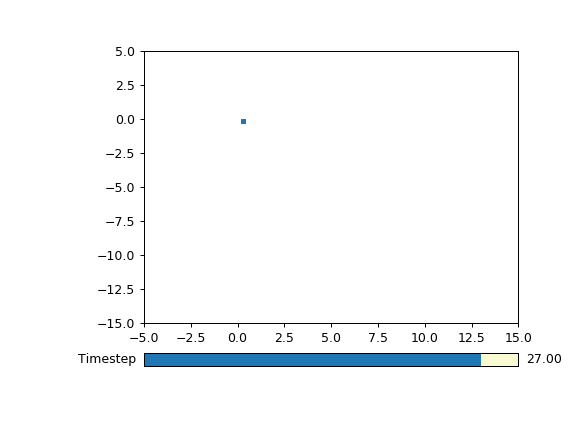

In [117]:
#visualization, provided by Varun
from matplotlib.widgets import Slider
%matplotlib notebook

fig, ax = plt.subplots()
time_stamps = np.arange(31)
t = np.arange(len(time_stamps))
PARTICLE_TIME = 0
plt.subplots_adjust(left=0.25, bottom=0.25)
particles_data, = plt.plot(particles[0,0], particles[0,1], '.')
ax.set_xlim(-5, 15)
ax.set_ylim(-15, 5)

axcolor = 'lightgoldenrodyellow'
timeax = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
timeSlider = Slider(timeax, 'Timestep', valmin=0, valmax=len(time_stamps)-1, valinit=0, valstep=1)

def update(val):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    PARTICLE_TIME = timeSlider.val
    particles_data.set_xdata(particles[PARTICLE_TIME, 0, :])
    particles_data.set_ydata(particles[PARTICLE_TIME, 1, :])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    fig.canvas.draw_idle()

timeSlider.on_changed(update)
plt.show()

In [80]:
test = np.ones(1000)/1000

In [81]:
np.random.choice(a = np.arange(1000), p = test)

254